In [114]:
import numpy as np 
import pandas as pd 
import altair as alt
from venn import venn 
import upsetplot
import matplotlib.pyplot as plt
from Commons.data_processing import *

In [115]:
# get data file
file = r'.\Working_Datafiles\All_N_Glycopeptides.csv'
df = pd.read_csv(file)

# organize contents
df = df.sort_values(['concentration', 'temperature'], ascending=[False, True])

# <b>What are our goals?</b>

1. Demonstrate that different temperatures yield different results
- Number of glycopeptides
- Number of unique peptide backbones
- Number of unique glycans
2. Demonstrate that glycopeptide subtypes are differing in response to temperature
- Do any classes resist this trend?
3. Show that sialylated glycopeptides are adversely affected
- Show change in number of terminal residues
4. What hypotheses can we eiliminate?

In [126]:
# How does performance change in accordance with temperature?

#  information to extract: num peptides, num unique glycans, num unique peptide backbones
temps, vals, kind, dilutions = [], [], [], []

for dilution, dil_frame in iterate_contents("dilution", df, get_item=True):
    for temp, temp_frame in iterate_contents("temperature", dil_frame, get_item=True):
        for run, run_frame in iterate_contents("run", temp_frame, get_item=True):

            unique_gly = len(run_frame.pep_mods.unique())
            dilutions.append(dilution)
            vals.append(unique_gly)
            temps.append(temp)
            kind.append("Unique Glycopeptides")

            unique_seq = len(run_frame.sequence.unique())
            dilutions.append(dilution)
            vals.append(unique_seq)
            temps.append(temp)
            kind.append("Unique Backbones")

            unique_glycans = len(run_frame.glycan.unique())
            dilutions.append(dilution)
            vals.append(unique_glycans)
            temps.append(temp)
            kind.append("Unique Glycans")

res = pd.DataFrame(
    {"Temperature": temps, "Kind": kind, "Values": vals, "Dilution": dilutions}
)

my_colors = alt.Color(
    "Temperature:N",
    scale=alt.Scale(
        domain=["30C", "45C", "60C"], range=["#6E6581", "#B0B2BB", "#6B8A97"]
    ),
)

conc_max_comparison = (
    alt.Chart(res)
    .mark_bar()
    .encode(
        x=alt.X("Temperature:N", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(Values):Q", title="Number of Identifications"),
        color=my_colors,
    )
).properties(width=75, height=75)

cmc_err_bars = (
    alt.Chart(res)
    .mark_errorbar(extent="stdev")
    .encode(
        x=alt.X("Temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(Values):Q", title=""),
    )
)

base = alt.layer(conc_max_comparison, cmc_err_bars).facet(
    column="Kind:N",
    spacing=50,
)

max_conc = base.transform_filter(alt.datum.Dilution == 1.0).properties(
    title="Temperature Differences, No Dilution"
)


all_conc = alt.vconcat()
for dilution in res.Dilution.unique():
    all_conc &= base.transform_filter(
        alt.datum.Dilution == dilution
    ).properties(title=f"Dilution = {dilution}")

all_conc


alt.VConcatChart(...)

### <b>Commentary</b>

At all concentrations tested, the numebr of unique glycopeptides decreases as temperature rises. This trend is generally conserved when considering the number of unique glycans identified, dave for the two highest concentrations. These analyses revealed comparable or elevated number of unique glycans identified at 45C with significantly reduces quantities at 60C -- these quantities are lower than those in the 30C experiments, agreeing with the majority of the dataset.

However, within each concentration and across the experiment. When looking at the venn diagrams, they are consistent at each concentration and across all experiments. Knowing this, the difference in glycopeptide identifications stems largely from the differences in glycans presented.

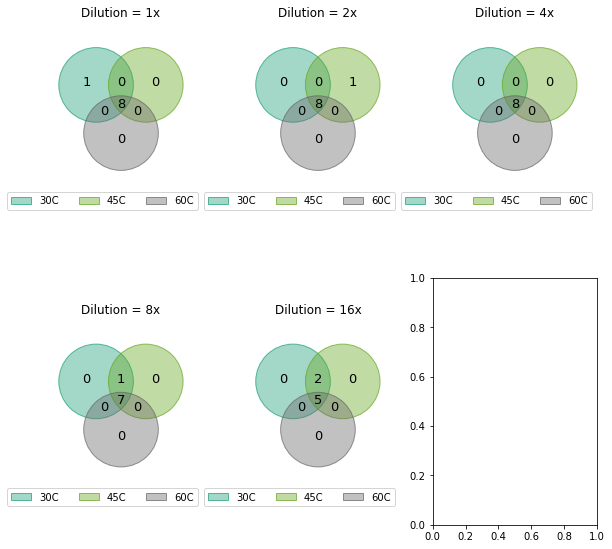

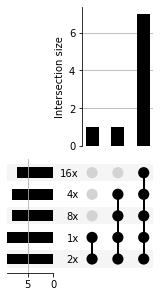

In [117]:
# How do the unique peptides compare across experiments?

global_overlap = dict()
for dilution, dil_frame in iterate_contents('dilution', df, get_item=True):
    global_overlap[dilution] = set(dil_frame.sequence.unique())
data = upsetplot.from_contents(global_overlap)


sample_overlap = dict()
dilutions = []

for dilution, dil_frame in iterate_contents("dilution", df, get_item=True):
    dilutions.append(dilution)
    d = dict()
    for temp, temp_frame in iterate_contents("temperature", dil_frame, get_item=True):
        d[temp] = set(temp_frame.sequence.unique())
    sample_overlap[dilution] = d

fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for i, dilution in enumerate(dilutions):
    ax = axs.flat[i]
    venn(sample_overlap[dilution], ax=ax, cmap='Dark2')
    ax.set_title(f'Dilution = {dilution}')
    ax.legend(list(sample_overlap[dilution].keys()), bbox_to_anchor=(1, 0), ncol=3)

upsetplot.plot(data)
None

In [118]:
glycan_sub = df[
    [
        "sequence",
        "glycan",
        "glycan_type",
        "pep_mods",
        "temperature",
        "concentration",
        "dilution",
        "run",
    ]
]

glycan_color_scale = alt.Scale(
    domain=[
        'Sialylated',
        'Fucosylated',
        'Complex',
        'Paucimannose',
        'High Mannose',
    ],
    range=[
        '#6E6581',
        '#AF3A53',
        '#6B8A97',
        '#B0B2BB',
        '#658A64',
    ]
)

bars = (
    alt.Chart(glycan_sub)
    .mark_bar()
    .encode(
        x=alt.X("temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(my_count):Q", title="# Matches"),
        color=alt.Color("glycan_type:N", scale=glycan_color_scale),
    )
    .transform_aggregate(
        my_count='count(glycan_type)',
        groupby=['glycan_type', 'concentration', 'temperature', 'run']
    )
).properties(width=50, height=75)

err = (
    alt.Chart(glycan_sub)
    .mark_errorbar(extent='stdev')
    .encode(
        x=alt.X("temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(my_count):Q", title="# Matches"),
    )
    .transform_aggregate(
        my_count='count(glycan_type)',
        groupby=['glycan_type', 'concentration', 'temperature', 'run']
    )
)

glyc_by_concentration = alt.layer(bars, err).facet(
    column=alt.Column('glycan_type', title=''),
    row='concentration:N'
)

glyc_by_concentration

alt.FacetChart(...)

### <b>Commentary</b>

When comparing the glycan classes identified in all experiments, we notice a few prevailing trends. At higher concentrations, both sialylated glycopeptides seem to show increased identification rates at 45 dgrees before dropping at 60C. This trend may also be seen in glycopeptides with complex glycans at most concentrations and for fucosylated glycopeptides at concentrations where they were detected.

High manoose glycopeptides, though showing deviation over the course of each experiment, largely resist this trend. This could explain our previous results that demonstrated higher identification rates of high mannose glycans as temperature increases. Of note, paucimannose glycopeptides tend to demonstrate a trend counter to the overarching concensus. These glycopeptides seem to increase in identification at 45C without a significant drop off at 60C. Why?  

In [119]:
df[df.degree_sial != '0']

,accession,description,checked,confidence,annotated_sequence,modifications,master_protein_accessions,num_psms,mz_da,charge,...,sequence,data_source,temperature,run,concentration,dilution,glycan,glycan_type,degree_sial,pep_mods
681,P61823,Ribonuclease pancreatic OS=Bos taurus OX=9913 ...,True,High,[R].NLTK.[D],1xHexNAc(3)Hex(6)NeuAc(1) [N1],P61823,1,1174.47034,2,...,NLTK,1_30C_Run3,30C,Run3,1.0000,1x,HexNAc(3)Hex(6)NeuAc(1),Sialylated,Monosialylated,NLTK_1xHexNAc(3)Hex(6)NeuAc(1) [N1]
682,P61823,Ribonuclease pancreatic OS=Bos taurus OX=9913 ...,True,High,[R].NLTK.[D],1xHexNAc(4)Hex(6)NeuAc(1) [N1],P61823,1,1276.01733,2,...,NLTK,1_30C_Run3,30C,Run3,1.0000,1x,HexNAc(4)Hex(6)NeuAc(1),Sialylated,Monosialylated,NLTK_1xHexNAc(4)Hex(6)NeuAc(1) [N1]
697,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(4)Hex(5)NeuGc(2) [N2],Q3SZR3,13,746.79547,4,...,QNGTLSK,1_30C_Run3,30C,Run3,1.0000,1x,HexNAc(4)Hex(5)NeuGc(2),Sialylated,Disialylated,QNGTLSK_1xHexNAc(4)Hex(5)NeuGc(2) [N2]
698,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].NPEYNK.[S],1xHexNAc(4)Hex(5)NeuAc(1)NeuGc(1) [N5],Q3SZR3,7,1493.06567,2,...,NPEYNK,1_30C_Run3,30C,Run3,1.0000,1x,HexNAc(4)Hex(5)NeuAc(1)NeuGc(1),Sialylated,Disialylated,NPEYNK_1xHexNAc(4)Hex(5)NeuAc(1)NeuGc(1) [N5]
699,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[K].CVYNCSFIK.[I],2xCarbamidomethyl [C1; C5]; 1xHexNAc(4)Hex(5)N...,Q3SZR3,33,1698.13953,2,...,CVYNCSFIK,1_30C_Run3,30C,Run3,1.0000,1x,HexNAc(4)Hex(5)NeuAc(2),Sialylated,Disialylated,CVYNCSFIK_2xCarbamidomethyl [C1; C5]; 1xHexNAc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,P12763,Alpha-2-HS-glycoprotein OS=Bos taurus OX=9913 ...,True,High,[K].LCPDCPLLAPLNDSR.[V],2xCarbamidomethyl [C2; C5]; 1xHexNAc(5)Hex(6)N...,P12763,28,1340.56177,3,...,LCPDCPLLAPLNDSR,00625_60C_Run3,60C,Run3,0.0625,16x,HexNAc(5)Hex(6)NeuAc(1),Sialylated,Monosialylated,LCPDCPLLAPLNDSR_2xCarbamidomethyl [C2; C5]; 1x...
638,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(4)Hex(5)NeuAc(1) [N2],Q3SZR3,5,1331.05359,2,...,QNGTLSK,00625_60C_Run3,60C,Run3,0.0625,16x,HexNAc(4)Hex(5)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(4)Hex(5)NeuAc(1) [N2]
640,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(3)Hex(4)NeuAc(1) [N2],Q3SZR3,4,1148.48328,2,...,QNGTLSK,00625_60C_Run3,60C,Run3,0.0625,16x,HexNAc(3)Hex(4)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(3)Hex(4)NeuAc(1) [N2]
655,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(4)Hex(5)NeuAc(1) [N2],Q3SZR3,5,1331.05847,2,...,QNGTLSK,00625_60C_Run2,60C,Run2,0.0625,16x,HexNAc(4)Hex(5)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(4)Hex(5)NeuAc(1) [N2]


In [104]:
test = df[
    [
        "sequence",
        "glycan",
        "glycan_type",
        "pep_mods",
        "temperature",
        "concentration",
        "run",
        "degree_sial",
    ]
]

test = test[test.degree_sial != "0"]

sial_color_scale = alt.Scale(
    domain=["Monosialylated", "Disialylated", "Trisialylated"],
    range=["#B0B2BB", "#6B8A97", "#AF3A53"],
)


sial = (
    alt.Chart(test)
    .mark_bar()
    .encode(
        x=alt.X("temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(my_count):Q", title="Glycan Count"),
        color=alt.Color("degree_sial:N", scale=sial_color_scale),
    )
    .transform_aggregate(
        my_count="count(degree_sial):Q",
        groupby=["temperature", "run", "concentration", "degree_sial"],
    )
).properties(width=50, height=75)

err = (
    alt.Chart(test)
    .mark_errorbar(extent="stdev")
    .encode(
        x=alt.X("temperature:N", title="", axis=alt.Axis(labelAngle=-45)),
        y=alt.Y("mean(my_count):Q", title=''),
    )
    .transform_aggregate(
        my_count="count(degree_sial):Q",
        groupby=["temperature", "run", "concentration", "degree_sial"],
    )
)

alt.layer(sial, err).facet(
    column=alt.Column("degree_sial:O"), row=alt.Row("concentration:Q")
)


alt.FacetChart(...)

In [139]:
test_case = df.loc[
    (df.concentration==1.0) &
    (df.glycan_type=='Sialylated'), :
]

sub_30 = test_case[test_case.temperature=='30C'].pep_mods.tolist()
sub_45 = test_case[test_case.temperature=='45C'].pep_mods.tolist()
sub_60 = test_case[test_case.temperature=='60C'].pep_mods.tolist()

set(sub_30) - set(sub_45)
set(sub_45) - set(sub_30)
set(sub_60) & set(sub_45)

{'CVYNCSFIK_2xCarbamidomethyl [C1; C5]; 1xHexNAc(4)Hex(5)NeuAc(1) [N4]',
 'LCPDCPLLAPLNDSR_2xCarbamidomethyl [C2; C5]; 1xHexNAc(4)Hex(5)NeuAc(2) [N12]',
 'LCPDCPLLAPLNDSR_2xCarbamidomethyl [C2; C5]; 1xHexNAc(5)Hex(5)NeuAc(1) [N12]',
 'LCPDCPLLAPLNDSR_2xCarbamidomethyl [C2; C5]; 1xHexNAc(5)Hex(6)NeuAc(1) [N12]',
 'NLTK_1xHexNAc(3)Hex(6)NeuAc(1) [N1]',
 'NLTK_1xHexNAc(4)Hex(5)Fuc(1)NeuAc(1) [N1]',
 'NPEYNK_1xHexNAc(4)Hex(5)NeuAc(1) [N5]',
 'NPEYNK_1xHexNAc(4)Hex(5)NeuAc(1)NeuGc(1) [N5]',
 'NPEYNK_1xHexNAc(4)Hex(5)NeuAc(2) [N5]',
 'NPEYNK_1xHexNAc(4)Hex(5)NeuGc(2) [N5]',
 'NPEYNK_1xHexNAc(4)Hex(6)Fuc(1)NeuAc(1) [N5]',
 'NPEYNK_1xHexNAc(5)Hex(6)NeuGc(1) [N5]',
 'QNGTLSK_1xHexNAc(3)Hex(4)NeuAc(1) [N2]',
 'QNGTLSK_1xHexNAc(4)Hex(5)NeuAc(1) [N2]',
 'QNGTLSK_1xHexNAc(4)Hex(5)NeuAc(1)NeuGc(1) [N2]',
 'QNGTLSK_1xHexNAc(4)Hex(5)NeuAc(2) [N2]',
 'QNGTLSK_1xHexNAc(4)Hex(5)NeuGc(2) [N2]'}

In [134]:
test_case = df.loc[
    (df.concentration==1.0) &
    (df.glycan_type=='Sialylated') &
    (df.degree_sial=='Monosialylated') &
    (df.sequence=='QNGTLSK'), :
]

In [135]:
test_case

,accession,description,checked,confidence,annotated_sequence,modifications,master_protein_accessions,num_psms,mz_da,charge,...,sequence,data_source,temperature,run,concentration,dilution,glycan,glycan_type,degree_sial,pep_mods
712,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(3)Hex(4)NeuAc(1) [N2],Q3SZR3,13,1148.97754,2,...,QNGTLSK,1_30C_Run3,30C,Run3,1.0,1x,HexNAc(3)Hex(4)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(3)Hex(4)NeuAc(1) [N2]
736,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(5)Hex(6)NeuAc(1) [N2],Q3SZR3,7,1513.60620,2,...,QNGTLSK,1_30C_Run3,30C,Run3,1.0,1x,HexNAc(5)Hex(6)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(5)Hex(6)NeuAc(1) [N2]
784,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(3)Hex(4)NeuAc(1) [N2],Q3SZR3,14,1148.47668,2,...,QNGTLSK,1_30C_Run1,30C,Run1,1.0,1x,HexNAc(3)Hex(4)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(3)Hex(4)NeuAc(1) [N2]
785,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(4)Hex(5)NeuAc(1) [N2],Q3SZR3,16,1331.04211,2,...,QNGTLSK,1_30C_Run1,30C,Run1,1.0,1x,HexNAc(4)Hex(5)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(4)Hex(5)NeuAc(1) [N2]
786,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(4)Hex(5)Fuc(1)NeuAc(1) [N2],Q3SZR3,5,936.38556,3,...,QNGTLSK,1_30C_Run1,30C,Run1,1.0,1x,HexNAc(4)Hex(5)Fuc(1)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(4)Hex(5)Fuc(1)NeuAc(1) [N2]
806,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(5)Hex(6)NeuAc(1) [N2],Q3SZR3,8,1513.61023,2,...,QNGTLSK,1_30C_Run1,30C,Run1,1.0,1x,HexNAc(5)Hex(6)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(5)Hex(6)NeuAc(1) [N2]
834,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(4)Hex(5)NeuAc(1) [N2],Q3SZR3,12,1331.04419,2,...,QNGTLSK,1_30C_Run3,30C,Run3,1.0,1x,HexNAc(4)Hex(5)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(4)Hex(5)NeuAc(1) [N2]
835,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(4)Hex(5)Fuc(1)NeuAc(1) [N2],Q3SZR3,6,936.38318,3,...,QNGTLSK,1_30C_Run3,30C,Run3,1.0,1x,HexNAc(4)Hex(5)Fuc(1)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(4)Hex(5)Fuc(1)NeuAc(1) [N2]
852,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(4)Hex(5)Fuc(1)NeuAc(1) [N2],Q3SZR3,9,936.38184,3,...,QNGTLSK,1_30C_Run2,30C,Run2,1.0,1x,HexNAc(4)Hex(5)Fuc(1)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(4)Hex(5)Fuc(1)NeuAc(1) [N2]
864,Q3SZR3,Alpha-1-acid glycoprotein OS=Bos taurus OX=991...,True,High,[R].QNGTLSK.[V],1xHexNAc(3)Hex(4)NeuAc(1) [N2],Q3SZR3,12,1148.47522,2,...,QNGTLSK,1_30C_Run2,30C,Run2,1.0,1x,HexNAc(3)Hex(4)NeuAc(1),Sialylated,Monosialylated,QNGTLSK_1xHexNAc(3)Hex(4)NeuAc(1) [N2]
